# Introduction

- In this notebook, we visualize and analyze eviction data in NYC using DBSCAN and K-means clustering algorithms. We continue with the previous notebook and visualize in Folium.

- Since the previous notebook has separated the COVID and pre-post-COVID periods, we will continue to analyze these two periods separately. Whenever necessary, we also break the whole of NYC into boroughs. Plot visuals have been proven minimally helpful, and therefore, we rely on Folium for cluster visualizations.  

- We ran DBSCAN on the data and assigned clusters. We analyzed the clusters and realized the limitations of DBSCAN in this case. We also noted the differences between boroughs' clusters.

- Most images not shown here to avoid git large files. All images will also be saved to the images folder.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# !pip install geopandas contextily
# # for google colab, had to reinstall some pacakges.


In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio
import contextily as ctx
from scipy.stats import f_oneway
from sklearn.decomposition import PCA

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# **Step 1 Get the Eviction data**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data source:
file_path1 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'
file_path2 = '/content/drive/My Drive/X999/evictions_covid.csv'

In [7]:
evictions_pre_post_raw = pd.read_csv(file_path1)
evictions_covid_raw = pd.read_csv(file_path2)
evictions_covid_raw.shape
# yay 22
# sometimes, it does take extra time and a new runtime for drive to return the updated file.

(6564, 22)

In [10]:
evictions_pre_post = evictions_pre_post_raw.copy()
evictions_covid = evictions_covid_raw.copy()

In [11]:
evictions_pre_post.head(2)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count
0,*308072/22_5865,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.6721,-73.8911,5.0000,37.0000,1152.0000,3083989,3037420029,East New York,2024,2024-12,POINT (-73.891105 40.672121),0.8000
1,*313639/23_5202,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.6359,-74.0119,7.0000,38.0000,118.0000,3143881,3057940012,Sunset Park East,2024,2024-03,POINT (-74.011883 40.635941),0.6000


In [12]:
evictions_covid.head(2)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count
0,004123/20_209969,004123/20,209969,2541 A GRAND AVE,ROOM 3B,2022-08-22,BRONX,10468,Not an Ejectment,Possession,40.8654,-73.9013,7.0000,14.0000,265.0000,2113173,2032140141,Kingsbridge Heights,2022,2022-08,POINT (-73.901317 40.865396),0.3333
1,0050153/20_106030,0050153/20,106030,98-05 67TH AVENUE,12F,2022-04-14,QUEENS,11375,Not an Ejectment,Possession,40.7242,-73.8556,6.0000,29.0000,71306.0000,4074666,4031560133,Forest Hills,2022,2022-04,POINT (-73.855552 40.724241),0.3333


In [13]:
evictions_pre_post.columns, \
evictions_covid.columns, \
evictions_pre_post.shape, \
evictions_covid.shape

(Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry', 'average_year_eviction_count'],
       dtype='object'),
 Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry', 'average_year_eviction_count'],
       dtype='object'),
 (76718, 22),
 (6564, 22))

# **Step 2 DBSCAN and its limitations**

- Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to partition data into clusters based on their distance to other points. Its effective at identifying and removing noise in a data set, making it useful for data cleaning and outlier detection.

##### https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F,their%20distance%20to%20other%20points.
##### https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

### Prepare the data for DBSCAN test

- Why didn't log the average eviction data points first?

- We have tried log it first before send the data for further processing, but it only yields one cluster. Therefore logging it just compress the data too much and therefore it is not a good way to process the data in this case

- We chose DBSCAN here, because it does not presumbly ask for the number of clusters, whereas K means does. K means also assume the clusters are in circular form, which may not be the case with geo data

In [14]:
evictions_covid.columns.tolist()

['primary_key',
 'court_index_number',
 'docket_number',
 'eviction_address',
 'eviction_apartment_number',
 'executed_date',
 'borough',
 'eviction_postcode',
 'ejectment',
 'eviction/legal_possession',
 'latitude',
 'longitude',
 'community_board',
 'council_district',
 'census_tract',
 'bin',
 'bbl',
 'nta',
 'year',
 'month_year',
 'geometry',
 'average_year_eviction_count']

## **Step 2.1: Get the elbow index**

Elbow index is derived from k-distance graph. it is the point where the radius of clustering makes sense. Will use it to find eps in dbscan.

In [15]:
# use eviction_count, laititude, longitudefor clustering
eviction_covid_counts = evictions_covid[['average_year_eviction_count','latitude', 'longitude']]
eviction_pre_post_counts = evictions_pre_post[['average_year_eviction_count','latitude', 'longitude']]

In [16]:
# normalize the eviction_counts
scaler = StandardScaler()
eviction_covid_scaled = scaler.fit_transform(eviction_covid_counts)
eviction_pre_post_scaled = scaler.fit_transform(eviction_pre_post_counts)

## **Step 2.2 Normal times**

In [17]:
neighbor = NearestNeighbors(n_neighbors=2)
# 2, because the closest neighbor is itself.
nbrs = neighbor.fit(eviction_pre_post_scaled)
distances, _ = nbrs.kneighbors(eviction_pre_post_scaled)

In [18]:
sorted_distances = np.sort(distances[:, 1])
n_points = len(sorted_distances)

In [19]:
x = np.arange(n_points)
y = sorted_distances

In [20]:
first = np.array([x[0], y[0]])
last = np.array([x[-1], y[-1]])
line_vec = last - first
line_vec_norm = line_vec / np.linalg.norm(line_vec)

In [21]:
vec_from_first = np.column_stack([x - first[0], y - first[1]])
cross_product = np.abs(np.cross(vec_from_first, line_vec_norm))
elbow_idx = np.argmax(cross_product)
elbow_value = sorted_distances[elbow_idx]

In [22]:
elbow_idx, elbow_value

(np.int64(75889), np.float64(0.024579165614198695))

### **Step 2.3 Covid**

In [23]:
neighbor = NearestNeighbors(n_neighbors=2)
# 2, because the closest neighbor is itself.
nbrs = neighbor.fit(eviction_covid_scaled)
distances, _ = nbrs.kneighbors(eviction_covid_scaled)
sorted_distances = np.sort(distances[:, 1])
n_points = len(sorted_distances)
x = np.arange(n_points)
y = sorted_distances
first = np.array([x[0], y[0]])
last = np.array([x[-1], y[-1]])
line_vec = last - first
line_vec_norm = line_vec / np.linalg.norm(line_vec)
vec_from_first = np.column_stack([x - first[0], y - first[1]])
cross_product = np.abs(np.cross(vec_from_first, line_vec_norm))
elbow_idx_c = np.argmax(cross_product)
elbow_value_c = sorted_distances[elbow_idx_c]
elbow_idx_c, elbow_value_c

(np.int64(6251), np.float64(0.042814597293910794))

In [76]:
# DBSCAN
# already tried 0.02458 for post and pre. Too many clusters (2000+), so we scale it here by 4 (a very generous scale,
# but it results in much less noise data and fewer clusters)
# we also increased min_samples to 5 (usual) to 15 for normal times

# We then used pca to reduce the data comperslexity but it is actually worse by having more points in cluster 0.
# So brought it back to just use the raw scaled data.

# We are doing all these to reduce computational complexity, reduce the number of datapoints in cluster 0
# reduce the number of noise, and form reasonable amount of clusters easier to viz and analyze
# also re-weighted kmeans later so that kmeans has more emphasize on eviction rates.
# https://academic.oup.com/bioinformatics/article/23/17/2247/260413

# pca = PCA(n_components=2)
# eviction_pca = pca.fit_transform(eviction_pre_post_scaled)
# eviction_covid_pca = pca.fit_transform(eviction_covid_scaled)
dbscan = DBSCAN(eps=0.02458*5, min_samples= 15, metric='euclidean')
dbscan_covid = DBSCAN(eps=0.04281*5, min_samples= 5, metric='euclidean')
evictions_covid['cluster'] = dbscan_covid.fit_predict(eviction_covid_scaled)
evictions_pre_post['cluster'] = dbscan.fit_predict(eviction_pre_post_scaled)
# 0.02458 is the elbow value, but it generates way too many noise points. so times 4

### **Covid**

In [77]:
n_clusters = len(set(evictions_covid['cluster'])) - (1 if -1 in evictions_covid['cluster'] else 0)
n_noise = list(evictions_covid['cluster']).count(-1)

In [78]:
print("results: number of clusters during covid: ", n_clusters, "number of noise points: ", n_noise, n_noise/6564)
print(f"{n_noise/6564}% noise")
# calculated below

results: number of clusters during covid:  54 number of noise points:  165 0.025137111517367458
0.025137111517367458% noise


In [79]:
total = evictions_covid.value_counts()

In [80]:
total.sum()

np.int64(6564)

In [81]:
395/(13+10+8+8+3+6522)
# 9.76% is in cluster noise

0.060176721511273616

In [82]:
evictions_covid.value_counts('cluster')

,count
cluster,
0,4107
2,650
3,624
11,221
-1,165
6,141
1,111
14,67
13,36


### **6% of the eviction data points are noise points. Better than expected.**

### **Normal Times**

In [83]:
# analyze the number of clusters formed and noise points
n_clusters = len(set(evictions_pre_post['cluster'])) - (1 if -1 in evictions_pre_post['cluster'] else 0)
n_noise = list(evictions_pre_post['cluster']).count(-1)

In [84]:
print("results: number of clusters during normal times as of dbscan: ", n_clusters, "number of noise points: ", n_noise)
print(f"ratio is {n_noise/76718}")
# calculated below

results: number of clusters during normal times as of dbscan:  199 number of noise points:  1471
ratio is 0.01917411819911885


In [85]:
total = evictions_pre_post.value_counts()

In [86]:
total.sum()

np.int64(76718)

In [87]:
3/(76718)

3.910425193566047e-05

In [88]:
evictions_pre_post.value_counts('cluster')
# so the majority is in cluster 0 too (75317)
# 2 noise points

,count
cluster,
0,65447
2,1917
-1,1471
4,1147
15,168
25,142
5,140
9,123
11,115


In [89]:
68900/ (76209+178 + 139+103+89)
# 89.80% of the data were classified as type 0 cluster with the mean, median, sta, max and min as:
# 1.0666, 0.6000, 1.4884, 14.8000, 0.2000

0.8980943194556689

In [90]:
# -1 would be noise label
print(evictions_pre_post['cluster'].unique())
print(evictions_covid['cluster'].unique())

[  0   1   2   3   4   5   6  -1   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84 166  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 182 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 164 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 165 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197]
[ 0  1 -1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52]


In [91]:
# evictions_pre_post.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid_clusters.csv')
# evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid_clusters.csv')
# will save them after re-ordering based on means or medians

In [128]:
# self defined 54 (covid) and 199 for non-covid here to match with HDBSCAN's answer
# kmeans = KMeans(n_clusters=32, random_state=42)
weighted_data = eviction_covid_scaled * [5, 1, 1]
evictions_covid['cluster_kmeans'] = KMeans(n_clusters=54).fit_predict(weighted_data)

In [130]:
# self defined 54 (covid) and 199 for non-covid here to match with HDBSCAN's answer
weighted_data = eviction_pre_post_scaled * [5, 1, 1]
evictions_pre_post['cluster_kmeans'] = KMeans(n_clusters=199).fit_predict(weighted_data)

# **Step 3: Reorder the cluster labels for covid, normal times with both dbscan and k-means**

## **Step 3.1 Reorder normal times**

Need to do the covid time, but there shouldn't be any surprises.

In [131]:
# let's do normal times first
cluster_means_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].mean()
cluster_counts_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].count()
cluster_medians_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].median()
cluster_stds_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].std()
cluster_maxs_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].max()
cluster_mins_pre_post = evictions_pre_post.groupby('cluster')['average_year_eviction_count'].min()

cluster_means_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].mean()
cluster_counts_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].count()
cluster_medians_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].median()
cluster_stds_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].std()
cluster_maxs_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].max()
cluster_mins_pre_post_k = evictions_pre_post.groupby('cluster_kmeans')['average_year_eviction_count'].min()

In [132]:
mean_series = pd.Series(cluster_means_pre_post, name = 'mean')
median_series = pd.Series(cluster_medians_pre_post, name = 'median')
std_series = pd.Series(cluster_stds_pre_post, name = 'std')
max_series = pd.Series(cluster_maxs_pre_post, name = 'max')
min_series = pd.Series(cluster_mins_pre_post, name = 'min')
count_series = pd.Series(cluster_counts_pre_post, name = 'count')

mean_series_k = pd.Series(cluster_means_pre_post_k, name = 'mean')
median_series_k = pd.Series(cluster_medians_pre_post_k, name = 'median')
std_series_k = pd.Series(cluster_stds_pre_post_k, name = 'std')
max_series_k = pd.Series(cluster_maxs_pre_post_k, name = 'max')
min_series_k = pd.Series(cluster_mins_pre_post_k, name = 'min')
count_series_k = pd.Series(cluster_counts_pre_post_k, name = 'count')
# renaming the name to avoid multi-index issues

In [133]:
# cluster_stats_dict = {
#     # ('pre_post', 'mean'): cluster_means_pre_post,
#     # ('pre_post', 'median'): cluster_medians_pre_post,
#     # ('pre_post', 'std'): cluster_stds_pre_post,
#     # ('pre_post', 'max'): cluster_maxs_pre_post,
#     # ('pre_post', 'min'): cluster_mins_pre_post,
#     # ('pre_post', 'count'): cluster_counts_pre_post
# }
cluster_stats_df = pd.concat([
    mean_series,
    median_series,
    std_series,
    max_series,
    min_series,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df
# these numbers are spread out and make more sense

,mean,median,std,max,min
cluster,,,,,
0,0.3369,0.2000,0.2244,1.4000,0.2000
1,0.2706,0.2000,0.0970,0.4000,0.2000
2,0.2870,0.2000,0.1502,0.8000,0.2000
3,0.2681,0.2000,0.1200,0.6000,0.2000
4,0.3161,0.2000,0.1614,0.6000,0.2000
5,0.3333,0.2000,0.1633,0.6000,0.2000
6,0.5997,0.4000,0.4427,2.0000,0.2000
7,0.7294,0.4000,0.6387,3.8000,0.2000
8,1.0750,1.0000,0.1000,1.2000,1.0000


In [134]:
cluster_stats_df_k = pd.concat([
    mean_series_k,
    median_series_k,
    std_series_k,
    max_series_k,
    min_series_k,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df_k

,mean,median,std,max,min
cluster_kmeans,,,,,
0,0.8909,0.8000,0.0998,1.0000,0.8000
1,27.8000,27.8000,0.0000,27.8000,27.8000
2,4.8048,4.8000,0.1516,5.0000,4.6000
3,13.4000,13.4000,0.0000,13.4000,13.4000
4,0.2000,0.2000,0.0000,0.2000,0.2000
5,2.0874,2.0000,0.0993,2.2000,2.0000
6,35.6000,35.6000,0.0000,35.6000,35.6000
7,0.5064,0.6000,0.1000,0.6000,0.4000
8,0.2000,0.2000,0.0000,0.2000,0.2000


In [135]:
sorted_medians = cluster_stats_df['median'].sort_values()
sorted_medians_k = cluster_stats_df_k['median'].sort_values()

In [136]:
cluster_mapping = {old: new for new, old in enumerate(sorted_medians.index)}
cluster_stats_df[('cluster', 'ordered')] = cluster_stats_df.index.map(cluster_mapping)
cluster_stats_df = cluster_stats_df.sort_values(('cluster', 'ordered'))
cluster_stats_df

,mean,median,std,max,min,"(cluster, ordered)"
cluster,,,,,,
0,0.3369,0.2000,0.2244,1.4000,0.2000,0
1,0.2706,0.2000,0.0970,0.4000,0.2000,1
2,0.2870,0.2000,0.1502,0.8000,0.2000,2
3,0.2681,0.2000,0.1200,0.6000,0.2000,3
4,0.3161,0.2000,0.1614,0.6000,0.2000,4
5,0.3333,0.2000,0.1633,0.6000,0.2000,5
6,0.5997,0.4000,0.4427,2.0000,0.2000,6
7,0.7294,0.4000,0.6387,3.8000,0.2000,7
8,1.0750,1.0000,0.1000,1.2000,1.0000,8


In [137]:
cluster_mapping_k = {old: new for new, old in enumerate(sorted_medians_k.index)}
cluster_stats_df_k[('cluster', 'ordered')] = cluster_stats_df_k.index.map(cluster_mapping_k)
cluster_stats_df_k = cluster_stats_df_k.sort_values(('cluster', 'ordered'))
cluster_stats_df_k

,mean,median,std,max,min,"(cluster, ordered)"
cluster_kmeans,,,,,,
4,0.2000,0.2000,0.0000,0.2000,0.2000,0
14,0.2665,0.2000,0.0943,0.4000,0.2000,1
15,0.2672,0.2000,0.0946,0.4000,0.2000,2
8,0.2000,0.2000,0.0000,0.2000,0.2000,3
31,0.2095,0.2000,0.0425,0.4000,0.2000,4
46,0.2827,0.2000,0.0986,0.4000,0.2000,5
36,0.2126,0.2000,0.0487,0.4000,0.2000,6
35,0.2729,0.2000,0.0964,0.4000,0.2000,7
48,0.2000,0.2000,0.0000,0.2000,0.2000,8


In [138]:
cluster_stats_df.columns

Index(['mean', 'median', 'std', 'max', 'min', ('cluster', 'ordered')], dtype='object')

In [139]:
cluster_stats_df.reset_index()

,cluster,mean,median,std,max,min,"(cluster, ordered)"
0,0,0.3369,0.2000,0.2244,1.4000,0.2000,0
1,1,0.2706,0.2000,0.0970,0.4000,0.2000,1
2,2,0.2870,0.2000,0.1502,0.8000,0.2000,2
3,3,0.2681,0.2000,0.1200,0.6000,0.2000,3
4,4,0.3161,0.2000,0.1614,0.6000,0.2000,4
5,5,0.3333,0.2000,0.1633,0.6000,0.2000,5
6,6,0.5997,0.4000,0.4427,2.0000,0.2000,6
7,7,0.7294,0.4000,0.6387,3.8000,0.2000,7
8,8,1.0750,1.0000,0.1000,1.2000,1.0000,8
9,9,1.2737,1.2000,0.0991,1.4000,1.2000,9


In [140]:
# overwrite the evictions_cleaned df:
evictions_pre_post['cluster'] = evictions_pre_post['cluster'].map(cluster_mapping)
evictions_pre_post['cluster_kmeans'] = evictions_pre_post['cluster_kmeans'].map(cluster_mapping_k)

In [141]:
overlap_counts = pd.crosstab(evictions_pre_post['cluster'], evictions_pre_post['cluster_kmeans'])
overlap_counts

cluster_kmeans,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,345,0,0,0,0,0,500,0,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0,336,0,0,0,0,0,0,0,0,0,289,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,0,156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,425,516,0,1302,759,0,602,543,0,640,0,830,1174,554,838,459,721,951,622,805,589,761,703,393,872,861,0,285,0,814,1044,453,395,705,616,0,459,786,760,842,376,800,798,255,568,0,544,761,503,713,398,666,499,885,653,738,683,487,1004,573,0,0,729,282,251,696,843,0,245,3

In [142]:
total_points = len(evictions_pre_post)
agree_count = sum(evictions_pre_post['cluster'] == evictions_pre_post['cluster_kmeans'])
disagree_count = total_points - agree_count
agree_count, disagree_count, 862/75856 # 38.81% overlapped after reordering

(1095, 75623, 0.011363636363636364)

In [143]:
agree_count/total_points, disagree_count/total_points

(0.014273051956516071, 0.9857269480434839)

In [144]:
evictions_pre_post.cluster_kmeans.nunique(), \
evictions_pre_post.cluster.nunique()

(199, 199)

In [145]:
reordered_overlap = pd.crosstab(evictions_pre_post['cluster_kmeans'], evictions_pre_post['cluster'])
reordered_overlap.head()

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,425,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,345,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1302,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,759,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
# plt.figure(figsize = (10, 6))
# sns.heatmap(reordered_overlap, cmap = 'YlGnBu')
# plt.title("Overlap: hdbscan vs. k-means")
# plt.xlabel("hdbscan cluster")
# plt.ylabel("kmeans cluster")
# plt.show()

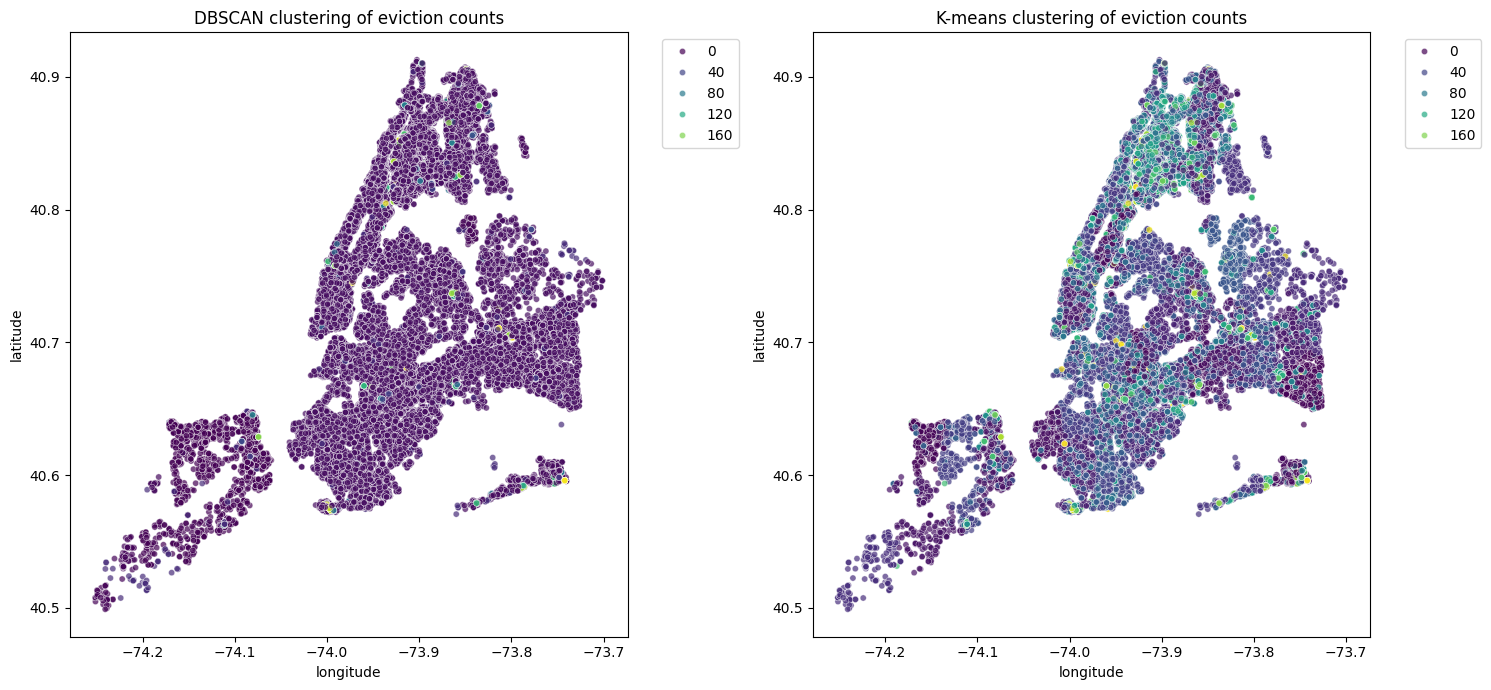

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster', data = evictions_pre_post,
                s = 20, palette='viridis', alpha = 0.7, ax = ax1)

ax1.set_title('DBSCAN clustering of eviction counts')
ax1.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster_kmeans', data = evictions_pre_post,
                s = 20, palette='viridis', alpha = 0.7, ax = ax2)

ax2.set_title('K-means clustering of eviction counts')
ax2.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.tight_layout()
plt.show()
# the type 0 is still a bit too overwhelming
# the kmeans is fairly geo-balanced.
# pca does not work
# kmeans actually makese more sense here.

In [148]:
evictions_pre_post.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid_clusters.csv')
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid_clusters.csv')

next: Do the covid one and then do the boroughs.  

```
# This is formatted as code
```



# **Let's dive into different borough's eviction landscape [carried over from the older version]**

### This also means, we are actually locating the particular types of clusters (the outliers) and where they came from

In [149]:
# manhattan
evictions_manhattan_covid = evictions_covid[evictions_covid['borough'] == 'MANHATTAN']
evictions_manhattan_pre_post = evictions_pre_post[evictions_pre_post['borough'] == 'MANHATTAN']
evictions_manhattan_covid.shape, \
evictions_manhattan_pre_post.shape
# the added column would be the cluster

((992, 24), (12060, 24))

In [150]:
# brooklyn
evictions_brooklyn_covid = evictions_covid[evictions_covid['borough'] == 'BROOKLYN']
evictions_brooklyn_pre_post = evictions_pre_post[evictions_pre_post['borough'] == 'BROOKLYN']
evictions_brooklyn_covid.shape, \
evictions_brooklyn_pre_post.shape

((2268, 24), (21713, 24))

In [151]:
# staten island
evictions_si_covid = evictions_covid[evictions_covid['borough'] == 'STATEN ISLAND']
evictions_si_pre_post = evictions_pre_post[evictions_pre_post['borough'] == 'STATEN ISLAND']
evictions_si_covid.shape, \
evictions_si_pre_post.shape

((332, 24), (2519, 24))

In [152]:
# bronx
evictions_bronx_covid = evictions_covid[evictions_covid['borough'] == 'BRONX']
evictions_bronx_pre_post = evictions_pre_post[evictions_pre_post['borough'] == 'BRONX']
evictions_bronx_covid.shape, \
evictions_bronx_pre_post.shape

((1895, 24), (26701, 24))

In [153]:
# queens
evictions_queens_covid = evictions_covid[evictions_covid['borough'] == 'QUEENS']
evictions_queens_pre_post = evictions_pre_post[evictions_pre_post['borough'] == 'QUEENS']
evictions_queens_covid.shape, \
evictions_queens_pre_post.shape

((1077, 24), (13725, 24))

## **Step 2.3 Analyze each borough's clustering patterns**

In [154]:
bronx_covid_stats = evictions_bronx_covid.groupby('cluster')['average_year_eviction_count'].describe()
bronx_covid_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,29.0000,1.1839,0.4679,0.3333,1.0000,1.3333,1.3333,2.0000
0,1215.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
3,436.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
4,28.0000,1.3333,0.0000,1.3333,1.3333,1.3333,1.3333,1.3333
6,132.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
20,7.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
22,6.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
23,5.0000,1.6667,0.0000,1.6667,1.6667,1.6667,1.6667,1.6667
32,5.0000,1.6667,0.0000,1.6667,1.6667,1.6667,1.6667,1.6667


In [155]:
bronx_pre_post_stats = evictions_bronx_pre_post.groupby('cluster')['average_year_eviction_count'].describe()
bronx_pre_post_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
4,31.0000,0.3161,0.1614,0.2000,0.2000,0.2000,0.4000,0.6000
7,23882.0000,1.0241,0.7867,0.2000,0.4000,0.8000,1.4000,3.8000
10,21.0000,1.4190,0.1662,1.2000,1.2000,1.4000,1.6000,1.6000
17,17.0000,1.7059,0.1029,1.6000,1.6000,1.8000,1.8000,1.8000
24,174.0000,9.0552,11.2764,0.4000,2.2000,2.8000,27.8000,27.8000
37,26.0000,2.6000,0.0000,2.6000,2.6000,2.6000,2.6000,2.6000
40,56.0000,2.8071,0.1425,2.6000,2.8000,2.8000,3.0000,3.0000
41,27.0000,2.7037,0.1018,2.6000,2.6000,2.8000,2.8000,2.8000
43,15.0000,3.0000,0.0000,3.0000,3.0000,3.0000,3.0000,3.0000


In [156]:
brooklyn_covid_stats = evictions_brooklyn_covid.groupby('cluster')['average_year_eviction_count'].describe()
brooklyn_covid_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,48.0000,2.1250,1.3625,1.0000,1.3333,1.3333,4.3333,4.3333
0,1457.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
1,111.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,511.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
5,6.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,6.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
9,24.0000,1.3333,0.0000,1.3333,1.3333,1.3333,1.3333,1.3333
10,26.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
21,6.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667


In [157]:
brooklyn_pre_post_stats = evictions_brooklyn_pre_post.groupby('cluster')['average_year_eviction_count'].describe()
brooklyn_pre_post_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
7,20007.0000,0.5661,0.4452,0.2000,0.2000,0.4000,0.8000,2.6000
9,19.0000,1.2737,0.0991,1.2000,1.2000,1.2000,1.4000,1.4000
11,27.0000,1.3704,0.1728,1.2000,1.2000,1.4000,1.6000,1.6000
12,21.0000,1.4000,0.0000,1.4000,1.4000,1.4000,1.4000,1.4000
14,15.0000,1.5067,0.1033,1.4000,1.4000,1.6000,1.6000,1.6000
19,17.0000,1.7059,0.1029,1.6000,1.6000,1.8000,1.8000,1.8000
20,38.0000,1.9053,0.1012,1.8000,1.8000,2.0000,2.0000,2.0000
23,21.0000,2.1048,0.1024,2.0000,2.0000,2.2000,2.2000,2.2000
24,487.0000,9.9700,14.1914,0.6000,2.0000,2.4000,2.8000,35.6000


In [158]:
# evictions_

In [159]:
si_covid_stats = evictions_si_covid.groupby('cluster')['average_year_eviction_count'].describe()
si_covid_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,20.0000,0.7333,0.2778,0.3333,0.5833,0.6667,1.0000,1.0000
8,20.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
11,221.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
12,18.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
24,8.0000,2.6667,0.0000,2.6667,2.6667,2.6667,2.6667,2.6667
25,6.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
26,6.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
41,6.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
42,8.0000,1.3333,0.0000,1.3333,1.3333,1.3333,1.3333,1.3333


In [160]:
si_pre_post_stats = evictions_si_pre_post.groupby('cluster')['average_year_eviction_count'].describe()
si_pre_post_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1917.0000,0.3369,0.2244,0.2000,0.2000,0.2000,0.4000,1.4000
1,34.0000,0.2706,0.0970,0.2000,0.2000,0.2000,0.4000,0.4000
3,47.0000,0.2681,0.1200,0.2000,0.2000,0.2000,0.4000,0.6000
5,15.0000,0.3333,0.1633,0.2000,0.2000,0.2000,0.4000,0.6000
24,119.0000,0.9361,0.6189,0.2000,0.4000,1.0000,1.2000,2.6000
25,21.0000,2.1048,0.1024,2.0000,2.0000,2.2000,2.2000,2.2000
26,39.0000,2.4974,0.2508,2.2000,2.2000,2.4000,2.8000,2.8000
31,79.0000,2.5443,0.1500,2.4000,2.4000,2.6000,2.6000,2.8000
35,27.0000,2.5111,0.1013,2.4000,2.4000,2.6000,2.6000,2.6000


In [161]:
queen_covid_stats = evictions_queens_covid.groupby('cluster')['average_year_eviction_count'].describe()
queen_covid_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,36.0000,0.9815,0.2383,0.6667,0.6667,1.0000,1.0000,1.3333
0,697.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
2,139.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
13,36.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
14,67.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
15,12.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
16,32.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
17,9.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
18,8.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667


In [162]:
queen_pre_post_stats = evictions_queens_pre_post.groupby('cluster')['average_year_eviction_count'].describe()
queen_pre_post_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
2,115.0000,0.2870,0.1502,0.2000,0.2000,0.2000,0.4000,0.8000
6,1147.0000,0.5997,0.4427,0.2000,0.2000,0.4000,0.8000,2.0000
7,10474.0000,0.4534,0.3803,0.2000,0.2000,0.4000,0.6000,2.2000
8,16.0000,1.0750,0.1000,1.0000,1.0000,1.0000,1.2000,1.2000
13,25.0000,1.6720,0.0980,1.6000,1.6000,1.6000,1.8000,1.8000
15,16.0000,1.6000,0.0000,1.6000,1.6000,1.6000,1.6000,1.6000
18,27.0000,1.8148,0.1657,1.6000,1.6000,1.8000,2.0000,2.0000
24,543.0000,3.5488,5.1609,0.2000,1.4000,2.0000,2.4000,17.8000
28,23.0000,2.3043,0.1022,2.2000,2.2000,2.4000,2.4000,2.4000


In [163]:
manhattan_covid_stats = evictions_manhattan_covid.groupby('cluster')['average_year_eviction_count'].describe()
manhattan_covid_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,32.0000,1.4583,0.4919,1.0000,1.0000,1.3333,1.3333,2.3333
0,738.0000,0.3333,0.0000,0.3333,0.3333,0.3333,0.3333,0.3333
3,188.0000,0.6667,0.0000,0.6667,0.6667,0.6667,0.6667,0.6667
4,4.0000,1.3333,0.0000,1.3333,1.3333,1.3333,1.3333,1.3333
6,9.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
19,6.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
30,6.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
33,9.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [164]:
manhattan_pre_post_stats = evictions_manhattan_pre_post.groupby('cluster')['average_year_eviction_count'].describe()
manhattan_pre_post_stats

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
7,11084.0000,0.6501,0.5173,0.2000,0.2000,0.4000,0.8000,3.0000
16,47.0000,1.9021,0.2080,1.6000,1.8000,1.8000,2.0000,2.2000
21,30.0000,2.0000,0.0000,2.0000,2.0000,2.0000,2.0000,2.0000
22,21.0000,2.1048,0.1024,2.0000,2.0000,2.2000,2.2000,2.2000
24,148.0000,4.9432,4.7744,1.6000,2.3500,2.8000,2.8000,13.8000
27,23.0000,2.3043,0.1022,2.2000,2.2000,2.4000,2.4000,2.4000
46,15.0000,3.0000,0.0000,3.0000,3.0000,3.0000,3.0000,3.0000
48,15.0000,3.0000,0.0000,3.0000,3.0000,3.0000,3.0000,3.0000
57,16.0000,3.2000,0.0000,3.2000,3.2000,3.2000,3.2000,3.2000


## **In short summary, in different boroughs, we have seen different clustering patterns. In Manhattan and Staten Island, we only observed one type of clustering in both covid and normal times (type 1, the least severe one). However, this does not mean they can't have buildings that had more than 10 evictions per year. Manhattan does during normal time. SI had more than 5 evictions per building per year during normal times. Queens had three types, except type 4, the most severe one, during normal times, and had only type 0 during covid time. Brooklyn had two types, 0 and 1 during both periods. Bronx had type 0 during covid and type 0 and type 4 during normal time, reaching maximum as high as 27.8 evictions per building per year.**